<a href="https://colab.research.google.com/github/ies9357/AIB_CP1_project/blob/main/Section6_CP1_EfficientNetB1_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#1.데이터 전처리

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

np.random.seed(42)
tf.random.set_seed(42)

(450, 600, 3)


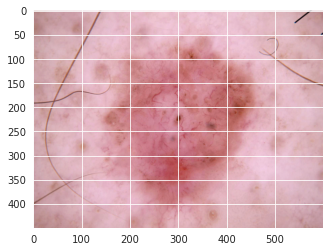

In [4]:
# 1장의 이미지(기저세포암종 - BCC) 확인

image_path=r'/content/drive/MyDrive/Colab Notebooks/Section6_CP1_project/cp1 데이터/BCC(기저 세포 암종)/ISIC_0024332.jpg'
img=plt.imread(image_path)
print(img.shape)
imshow(img);

(300, 300, 3)


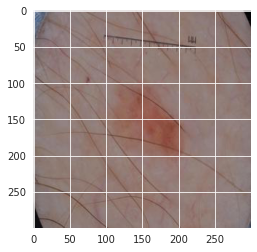

In [5]:
image_path=r'/content/drive/MyDrive/Colab Notebooks/Section6_CP1_project/cp1 데이터/malignant(흑색종 악성)/melanoma_10116.jpg'
img=plt.imread(image_path)
print(img.shape)
imshow(img);

##1]. 피부암 이미지의 데이터프레임 구축

In [6]:
images_dir = '/content/drive/MyDrive/Colab Notebooks/Section6_CP1_project/cp1 데이터'
class_list = os.listdir(images_dir)
class_list

['benign(흑색종 양성)',
 'malignant(흑색종 악성)',
 'nevus(모반)',
 'seborrheic_keratosis(지루성 각화증)',
 'BCC(기저 세포 암종)']

In [7]:
# 파일경로와 라벨에 대한 데이터 프레임 만들기

images_dir = '/content/drive/MyDrive/Colab Notebooks/Section6_CP1_project/cp1 데이터'
class_list = os.listdir(images_dir) # ['benign(흑색종 양성)', 'malignant(흑색종 악성)', 'nevus(모반)', 'seborrheic_keratosis(지루성 각화증)', 'BCC(기저 세포 암종)'] << os.listdir(images_dir)

file_pathes = []
labels = []

# file이름의 list들을 file_paths에 저장
for cls in class_list:
  class_path = os.path.join(images_dir, cls) # 하나의 클래스 폴더[ex. 'benign(흑색종 양성)', 'malignant(흑색종 악성)']의 경로
  file_list = os.listdir(class_path) # 폴더(class_path) 내 모든 파일리스트 출력

  for f in file_list:
    file_path = os.path.join(class_path, f) # 클래스 폴더의 경로에 파일 이름을 붙혀 파일경로 생성
    file_pathes.append(file_path) # 파일경로를 하나하나씩 붙여 파일경로 리스트 생성
    labels.append(cls) # 파일 경로 하나하나에 대한 라벨들을 labels라는 리스트에 붙힘

file_series = pd.Series(file_pathes, name = 'file_pathes')
label_series = pd.Series(labels, name = 'labels')
df = pd.concat([file_series, label_series], axis = 1)

In [8]:
df

,file_pathes,labels
0,/content/drive/MyDrive/Colab Notebooks/Section...,benign(흑색종 양성)
1,/content/drive/MyDrive/Colab Notebooks/Section...,benign(흑색종 양성)
2,/content/drive/MyDrive/Colab Notebooks/Section...,benign(흑색종 양성)
3,/content/drive/MyDrive/Colab Notebooks/Section...,benign(흑색종 양성)
4,/content/drive/MyDrive/Colab Notebooks/Section...,benign(흑색종 양성)
...,...,...
20068,/content/drive/MyDrive/Colab Notebooks/Section...,BCC(기저 세포 암종)
20069,/content/drive/MyDrive/Colab Notebooks/Section...,BCC(기저 세포 암종)
20070,/content/drive/MyDrive/Colab Notebooks/Section...,BCC(기저 세포 암종)
20071,/content/drive/MyDrive/Colab Notebooks/Section...,BCC(기저 세포 암종)


In [9]:
df['labels'].value_counts()

nevus(모반)                              8548
benign(흑색종 양성)                  5510
malignant(흑색종 악성)               5115
BCC(기저 세포 암종)                      514
seborrheic_keratosis(지루성 각화증)     386
Name: labels, dtype: int64

In [10]:
round(df['labels'].value_counts(normalize = True) * 100, 2)

nevus(모반)                              42.58
benign(흑색종 양성)                  27.45
malignant(흑색종 악성)               25.48
BCC(기저 세포 암종)                      2.56
seborrheic_keratosis(지루성 각화증)     1.92
Name: labels, dtype: float64

In [11]:
a = df['file_pathes'][df['labels'] == 'BCC(기저 세포 암종)'].iloc[200]
image_path = r'{}'.format(a)
img_shape = plt.imread(image_path).shape
img_shape

# BCC(기저 세포 암종)의 이미지 크기 : (450, 600, 3)
# 나머지 클래스의 이미지 크기 : (300, 300, 3)

(450, 600, 3)

In [12]:
# benign_image_pathes = df['file_pathes'][df['labels'] == 'benign(흑색종 양성)']
# size_list = []

# for i in benign_image_pathes:
#   image_path= i
#   img_shape = plt.imread(image_path).shape

#   if img_shape not in size_list:
#     size_list.append(img_shape)

# size_list

##2]. 데이터프레임 전처리

In [13]:
# 데이터프레임 전처리 & 분할


train_df, dummy_df = train_test_split(df, train_size = 0.9, shuffle = True,
                                      random_state = 123)
valid_df, test_df=train_test_split(dummy_df, train_size = 0.5,
                                   shuffle = True, random_state = 123)
print('train_df의 크기 : {}\ntest_df의 크기 : {}\nvalid_df[validation dataframe]의 크기 : {}'.format(len(train_df), len(test_df), len(valid_df)))

train_labels_count = train_df['labels'].value_counts()
train_labels_count_norm = round(train_df['labels'].value_counts(normalize = True) * 100, 2)
# for b in balance:
#     print (b)


train_df의 크기 : 18065
test_df의 크기 : 1004
valid_df[validation dataframe]의 크기 : 1004


In [14]:
train_labels_count

nevus(모반)                              7695
benign(흑색종 양성)                  4979
malignant(흑색종 악성)               4577
BCC(기저 세포 암종)                      474
seborrheic_keratosis(지루성 각화증)     340
Name: labels, dtype: int64

In [15]:
train_labels_count_norm # 상태가 정상인 라벨이 거의 절반을 차지함 >> 불균형 데이터

nevus(모반)                              42.60
benign(흑색종 양성)                  27.56
malignant(흑색종 악성)               25.34
BCC(기저 세포 암종)                      2.62
seborrheic_keratosis(지루성 각화증)     1.88
Name: labels, dtype: float64

In [16]:
min(train_labels_count)

340

In [17]:
# sample_list = []
# max_size = max(train_labels_count)
# min_size = 0

# groups = train_df.groupby('labels')

# for label in train_df['labels'].unique():                 
#     group = groups.get_group(label)

# ['malignant(흑색종 악성)',
# 'benign(흑색종 양성)',
# 'nevus(모반)',
# 'seborrheic_keratosis(지루성 각화증)',
# 'BCC(기저 세포 암종)']

['malignant(흑색종 악성)',
 'benign(흑색종 양성)',
 'nevus(모반)',
 'seborrheic_keratosis(지루성 각화증)',
 'BCC(기저 세포 암종)']

In [18]:
pd.DataFrame(train_df['file_pathes'])

,file_pathes
5989,/content/drive/MyDrive/Colab Notebooks/Section...
4644,/content/drive/MyDrive/Colab Notebooks/Section...
16427,/content/drive/MyDrive/Colab Notebooks/Section...
7592,/content/drive/MyDrive/Colab Notebooks/Section...
4806,/content/drive/MyDrive/Colab Notebooks/Section...
...,...
7763,/content/drive/MyDrive/Colab Notebooks/Section...
15377,/content/drive/MyDrive/Colab Notebooks/Section...
17730,/content/drive/MyDrive/Colab Notebooks/Section...
15725,/content/drive/MyDrive/Colab Notebooks/Section...


In [37]:
# 불균형 데이터로 인한 학습문제를 해결하기 위해 oversampling 진행

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

ros = RandomOverSampler(random_state = 42) # ros : random over sampler(랜덤 오버샘플러)
file_pathes_over, labels_over = ros.fit_resample(pd.DataFrame(train_df['file_pathes']), pd.DataFrame(train_df['labels']))
train_df_over = pd.concat([file_pathes_over, labels_over], axis = 1).sample(6000, replace = False, weights = None,
                             random_state = 123,
                             axis = 0).reset_index(drop = True)
train_df_over

,file_pathes,labels
0,/content/drive/MyDrive/Colab Notebooks/Section...,malignant(흑색종 악성)
1,/content/drive/MyDrive/Colab Notebooks/Section...,nevus(모반)
2,/content/drive/MyDrive/Colab Notebooks/Section...,malignant(흑색종 악성)
3,/content/drive/MyDrive/Colab Notebooks/Section...,seborrheic_keratosis(지루성 각화증)
4,/content/drive/MyDrive/Colab Notebooks/Section...,seborrheic_keratosis(지루성 각화증)
...,...,...
5995,/content/drive/MyDrive/Colab Notebooks/Section...,malignant(흑색종 악성)
5996,/content/drive/MyDrive/Colab Notebooks/Section...,benign(흑색종 양성)
5997,/content/drive/MyDrive/Colab Notebooks/Section...,malignant(흑색종 악성)
5998,/content/drive/MyDrive/Colab Notebooks/Section...,seborrheic_keratosis(지루성 각화증)


In [38]:
# 훈련 데이터셋의 경로 데이터프레임에 대한 oversampling 진행 후 결과 확인

# 레이블 별 비율 
train_df_over['labels'].value_counts(normalize = True)

seborrheic_keratosis(지루성 각화증)    0.201833
malignant(흑색종 악성)               0.201000
nevus(모반)                              0.200000
BCC(기저 세포 암종)                     0.199000
benign(흑색종 양성)                  0.198167
Name: labels, dtype: float64

In [39]:
# 레이블 별 개수
train_df_over['labels'].value_counts()

seborrheic_keratosis(지루성 각화증)    1211
malignant(흑색종 악성)               1206
nevus(모반)                              1200
BCC(기저 세포 암종)                     1194
benign(흑색종 양성)                  1189
Name: labels, dtype: int64

In [50]:
# create train, test, valid generators

height = 256
width = 256
channels = 3
batch_size = 40
img_shape = (height, width, channels)
img_size = (height, width)
length = len(test_df) # 1004

In [51]:
test_batch_size = sorted([int(length / n) for n in range(1, length + 1) \
                          if length % n == 0 and length / n <= 80], \
                         reverse = True)[0]  
test_steps = int(length/test_batch_size)
print('test셋의 batch size : {}\ntest셋의 steps: \
{}'.format(test_batch_size, test_steps))


test셋의 batch size : 4
test셋의 steps: 251


##3]. 이미지 전처리

In [52]:
# ImageDataGenerator를 통한 데이터 증강, 데이터 파이프라인 구축

# 참고 :  : https://techblog-history-younghunjo1.tistory.com/252?category=922523

def scalar(img):
  # img = img / 127.5 - 1
  return img

trgen = ImageDataGenerator(preprocessing_function = scalar,
                           horizontal_flip = True)
tvgen = ImageDataGenerator(preprocessing_function = scalar)

train_gen = trgen.flow_from_dataframe(train_df_over, x_col = 'file_pathes',
                                      y_col = 'labels',
                                      target_size = img_size,
                                      class_mode = 'categorical',
                                      color_mode = 'rgb', shuffle = True,
                                      batch_size = batch_size)

test_gen = tvgen.flow_from_dataframe(test_df, x_col = 'file_pathes',
                                     y_col = 'labels',
                                     target_size = img_size,
                                     class_mode = 'categorical',
                                     color_mode = 'rgb', shuffle = False,
                                     batch_size = test_batch_size)

valid_gen = tvgen.flow_from_dataframe(valid_df, x_col = 'file_pathes',
                                      y_col = 'labels',
                                      target_size = img_size,
                                      class_mode = 'categorical',
                                      color_mode = 'rgb', shuffle = True,
                                      batch_size = batch_size)


Found 6000 validated image filenames belonging to 5 classes.
Found 1004 validated image filenames belonging to 5 classes.
Found 1004 validated image filenames belonging to 5 classes.


In [53]:
classes = list(train_gen.class_indices.keys()) # ['BCC(기저 세포 암종)', 'benign(흑색종 양성)', 'malignant(흑색종 악성)', 'nevus(모반)', 'seborrheic_keratosis(지루성 각화증)']
class_count = len(classes) # 5
train_steps = int(len(train_gen.labels) / batch_size) # 451 / len(train_gen.labels) = 18065


In [54]:
len(train_gen.labels)

6000

In [55]:
# 이미지의 몇몇 예를 보여주는 함수를 만들어보자.

def show_image_samples(gen):
  t_dict = gen.class_indices # key값(클래스)에 숫자 할당 : {'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}
  classes = list(t_dict.keys()) # t_dict에서 key값 소환 : ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
  images, labels = next(gen) # train_df에 있는 이미지와 레이블을 40개씩 불러온다.
  plt.figure(figsize=(20, 20))
  length=len(labels)

  if length < 25:
    r = length
  else:
    r = 25

  for i in range(r):
    plt.subplot(5, 5, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color = 'blue', fontsize = 16)
    plt.axis('off')
  plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4370 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4467 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4520 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4361 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4450 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4364 missing from current font.
  font.set_text(s

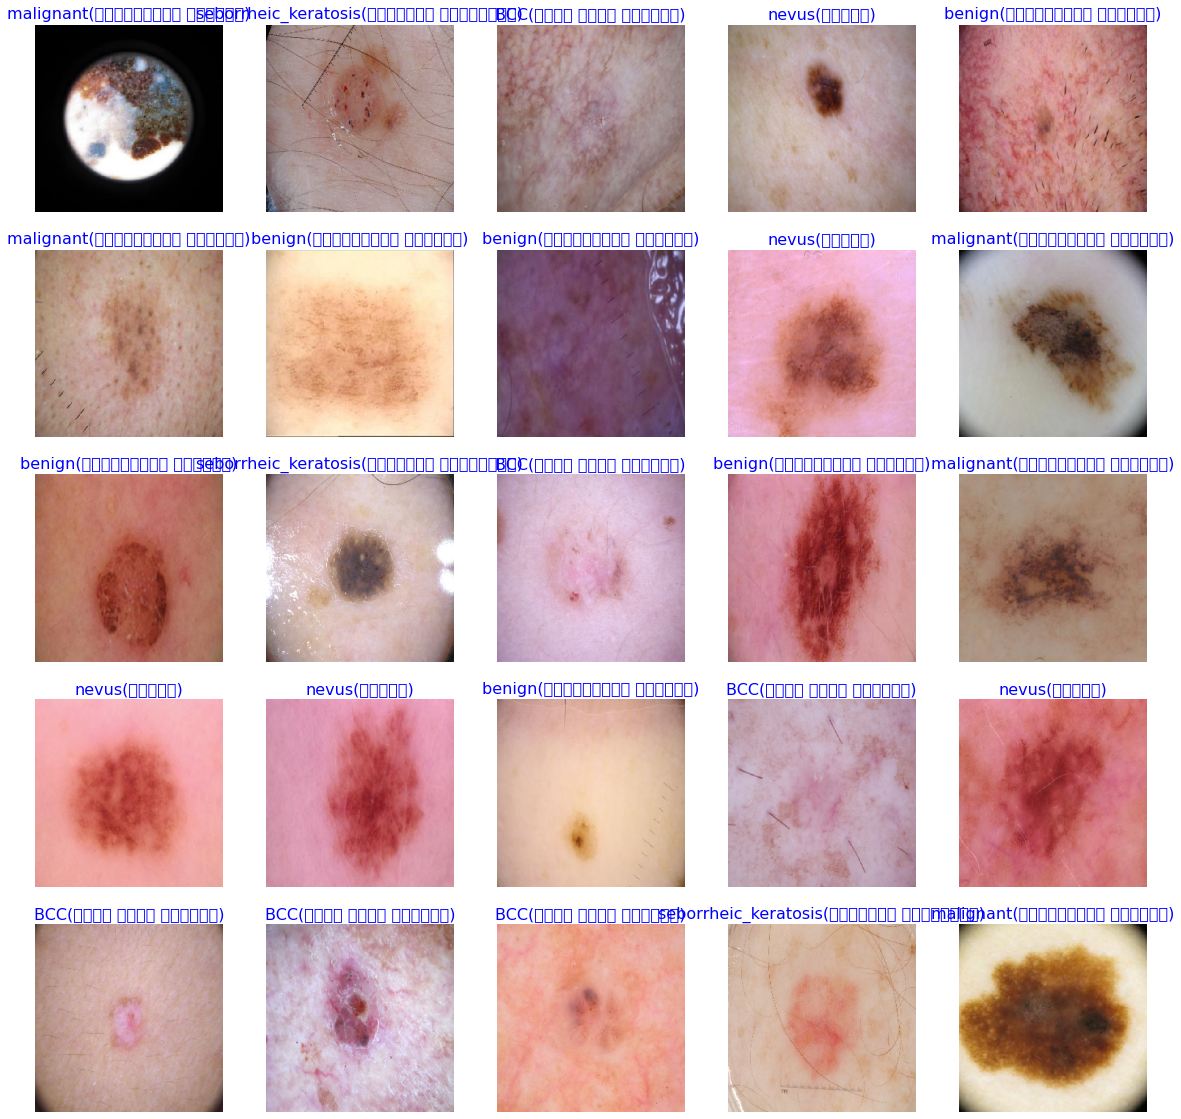

In [56]:
show_image_samples(train_gen)

In [58]:
# 모델 학습 시, 모델학습과정을 볼 수 있는 텍스트에 대하여
# RGB 전경색 및 배경색으로 꾸며주는 함수를 정의한다.

def print_in_color(txt_msg, fore_tupple, back_tupple,):
    # back_tupple에서 지정한 배경과 함께 fore_tupple에서 지정한 전경색으로 text_msg를 인쇄합니다.
    # text_msg는 텍스트, fore_tupple은 전경색 튜플(r,g,b), back_tupple은 배경 튜플(r,g,b)을 뜻한다.

    rf, gf, bf = fore_tupple
    rb, gb, bb = back_tupple
    msg = '{0}' + txt_msg
    mat = '\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg.format(mat), flush = True)
    print('\33[0m', flush=True) # 기본 인쇄 색상을 검정색으로 되돌린다.
    return

#2.모델학습

##1]. 사전학습 모델을 통한 모델 구성

In [59]:
# 모델 구성

model_name = 'EfficientNetB1'
# 사전학습모델을 EfficientNetB1로 한 이유

# 1. 여러 논문에 따르면 EfficientNet-B1의 x-ray이미지와 같이 분별성능의
# 판별 accuracy가 다른 사전학습모델(VGG16, MobileNet, AlexNet, GoogLeNet, Resnet50 등)들과
# 비교했을 때 상위권에 속함.

# 2. Kaggle에서 EfficientNetB1관련 자료가 많았음


base_model = tf.keras.applications.EfficientNetB1(include_top = False,
weights = 'imagenet', input_shape = img_shape, pooling = 'max')

x = base_model.output
x = keras.layers.BatchNormalization(axis = -1, momentum = 0.99,
                                    epsilon = 0.001)(x)

x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),
          activity_regularizer = regularizers.l1(0.006),
          bias_regularizer = regularizers.l1(0.006),
          activation = 'relu')(x)

x = Dropout(rate = .45, seed = 123)(x)
output = Dense(class_count, activation = 'softmax')(x)

model = Model(inputs = base_model.input, outputs = output)
model.compile(Adamax(lr=.001),
              loss='categorical_crossentropy',
              metrics=['accuracy']) 


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


##2]. Callback 함수 구성

In [60]:
# callback 함수 정의

class LRA(keras.callbacks.Callback):
    def __init__(self, model, base_model, patience, stop_patience, threshold, factor, dwell, batches, initial_epoch, epochs, ask_epoch):
        super(LRA, self).__init__()
        self.model = model
        self.base_model = base_model
        self.patience = patience # 학습률이 조정되기 전에 개선되지 않은 Epoch의 수를 지정한다.
        self.stop_patience = stop_patience # 훈련을 중지하기 위해 개선 없이 얼마나 lr을 조정할 것인지 지정
        self.threshold = threshold # 학습률이 검증 손실에 따라 조절될 때 훈련 정확도의 임계점을 명시한다.
        self.factor = factor # Learning rate를 얼마나 감소시킬 지 정하는 인자값 ex). 현재 lr이 0.01이고 factor가 0.8일 때, 콜백함수가 실행된다면 그 다음 lr은 0.008
        self.dwell = dwell
        self.batches = batches # Epoch당 실행할 training 배치 수
        self.initial_epoch = initial_epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # 만일 훈련을 다시 시작한다면 회복할 ask_epoch값 저장
        # callback 변수들 
        self.count = 0 # 성능의 개선없이 학습률이 몇 번 감소했는지에 대한 수치
        self.stop_count = 0        
        self.best_epoch = 1   # loss가 가장 적은 epoch        
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # 초기 학습률을 구한 뒤 저장한다. 
        self.highest_tracc = 0.0 # 처음에 가장 높은 훈련 정확도를 0으로 설정한다.
        self.lowest_vloss = np.inf # 처음에 가장 낮은 validation loss를 무한대로 지정한다.
        self.best_weights = self.model.get_weights() # 모델의 초기 가중치에 가장 적합한 가중치를 설정한다.
        self.initial_weights = self.model.get_weights()   # 복원해야 하는 경우 초기 가중치를 저장합니다.
        
    def on_train_begin(self, logs=None):        
        if self.base_model != None:
            status=base_model.trainable
            if status:
                msg=' initializing callback starting train with base_model trainable'
            else:
                msg='initializing callback starting training with base_model not trainable'
        else:
            msg='initialing callback and starting training'                        
        print_in_color (msg, (244, 252, 3), (55,65,80)) 
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration')
        print_in_color(msg, (244,252,3), (55,65,80)) 
        self.start_time= time.time()
        
    def on_train_end(self, logs=None):
        stop_time=time.time()
        tr_duration= stop_time- self.start_time            
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        self.model.set_weights(self.best_weights) # 모델의 가중치를 최상의 가중치로 설정
        msg=f'Training is completed - model is set with weights from epoch {self.best_epoch} '
        print_in_color(msg, (0,255,0), (55,65,80))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color(msg, (0,255,0), (55,65,80))   
        
    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  # 훈련 정확도를 얻는다.
        loss=logs.get('loss')
        msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') # 실행 중인 배치 카운트를 표시하기 위해 동일한 라인에 인쇄한다.      
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  # 각 epoch끝에 작동하는 함수
        later=time.time()
        duration=later-self.now 
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # 현재 학습률을 얻는다.
        current_lr=lr
        v_loss=logs.get('val_loss')  # 해당 epoch에 대한 validation loss를 얻는다.
        acc=logs.get('accuracy')  # 훈련 정확도를 얻는다.
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')        
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if acc>self.highest_tracc: # epoch에서 개선된 훈련 정확도
                self.highest_tracc=acc # 새로 갱신된 최고 훈련 정확도를 지정한다.
                self.best_weights=self.model.get_weights() # 훈련정확도가 향상되어 가중치를 저장한다.
                self.count=0 # 훈련 정확도가 향상되었으므로 count를 0으로 설정한다.
                self.stop_count=0 # stop_count[정지 카운터]를 0으로 설정
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.best_epoch=epoch + 1  # 현재 epoch에 대한 최상의 epoch 값을 설정한다.
            else: 
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1: # lr should be adjusted
                    color=(245, 170, 66)
                    lr= lr* self.factor # Learning rate를 얼마나 감소시킬 지 정하는 인자값
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count=0 # reset counter
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1 # increment patience counter                    
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if v_loss< self.lowest_vloss: # check if the validation loss improved 
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                self.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved  
                self.stop_count=0  
                color=(0,255,0)                
                self.best_epoch=epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count>=self.patience-1: # need to adjust lr
                    color=(245, 170, 66)
                    lr=lr * self.factor # patience 학습률을 factor만큼 조절함                 
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted 
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space
                else: 
                    self.count =self.count +1 # increment the patience counter                    
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,255), (55,65,80))
            self.model.stop_training = True # stop training
        else: 
            if self.ask_epoch !=None:
                if epoch + 1 >= self.ask_epoch:
                    msg='enter H to halt ,F to fine tune model, or an integer for number of epochs to run then ask again'
                    print_in_color(msg, (0,255,255), (55,65,80))
                    ans=input('')
                    if ans=='H' or ans=='h':
                        msg=f'training has been halted at epoch {epoch + 1} due to user input'
                        print_in_color(msg, (0,255,255), (55,65,80))
                        self.model.stop_training = True # stop training
                    elif ans == 'F' or ans=='f':
                        msg='setting base_model as trainable for fine tuning of model'
                        self.base_model.trainable=True
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80))                         
                        self.count=0
                        self.stop_count=0                        
                        self.ask_epoch = epoch + 1 + self.ask_epoch_initial 
                        
                    else:
                        ans=int(ans)
                        self.ask_epoch +=ans
                        msg=f' training will continue until epoch ' + str(self.ask_epoch)                         
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80)) 

##3]. 모델학습 진행

In [61]:

# 사용자 정의 콜백을 객체화 하고 모델학습을 진행한다.

epochs = 5
patience= 1 # 모니터링 되는 값이 개선되지 않을 경우 학습률을 조절하기 위해 기다릴 epoch수
stop_patience =3 # 모니터링된 값이 개선되지 않는 경우 훈련을 중지하기 전에 기다릴 에포크 수
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # 학습률 감소 factor
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch

ask_epoch=2 # 훈련을 중단할 것인지 묻기 전에 실행할 에포크 수
batches=train_steps
callbacks=[LRA(model=model,base_model= base_model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]

history=model.fit(x=train_gen, epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 initializing callback starting train with base_model trainable

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration

 1 /5      6.403   84.783   4.95018  90.837   0.00100  0.00100  accuracy  3321.46 

 2 /5      3.848   93.500   3.14798  91.932   0.00100  0.00100  val_loss   375.55 

enter H to halt ,F to fine tune model, or an integer for number of epochs to run then ask again

F
setting base_model as trainable for fine tuning of model

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration

 3 /5      2.445   95.350   2.00460  92.729   0.00100  0.00100  val_loss   372.53 

 4 /5      1.587   96.517   1.36966  92.928   0.00100  0.00100  val_loss   376.07 

enter H to halt ,F to fine tune model, or an integer for number of epochs to run then ask again

F
setting base_model as trainable for fine tuning of model

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration

 5 /5      1.032   97.450   0.93805 

In [62]:
# 모델 학습기록 저장
import pickle

with open('/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

#3.모델평가

In [63]:
# 훈련 데이터를 plot하기 위한 함수 정의

def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [64]:
# confusion matrix와 classification report를 만들기 위한 함수 정의

def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

    return y_true, y_pred

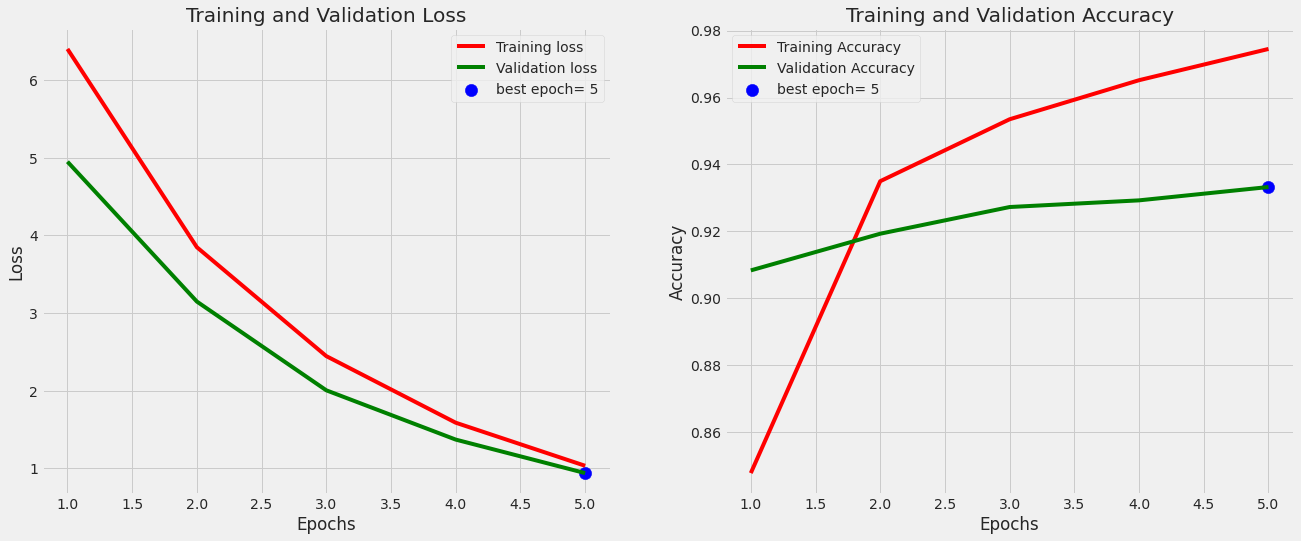

251/251 [==============================] - 942s 4s/step - loss: 0.9186 - accuracy: 0.9353
accuracy on the test set is 93.53 %



In [65]:
# 테스트 셋으로 모델을 평가 & 모델 저장

tr_plot(history,0)
save_dir=r'./'
subject='covid'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4370 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4467 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4520 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4361 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4450 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4364 missing from current font.
  font.set_text(s

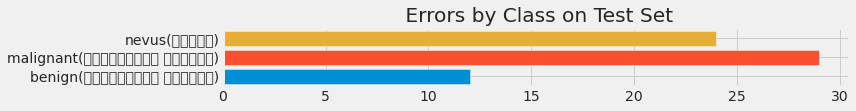

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4352 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4469 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4454 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4369 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4535 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4357 missing from current font.
  font.set_text(s

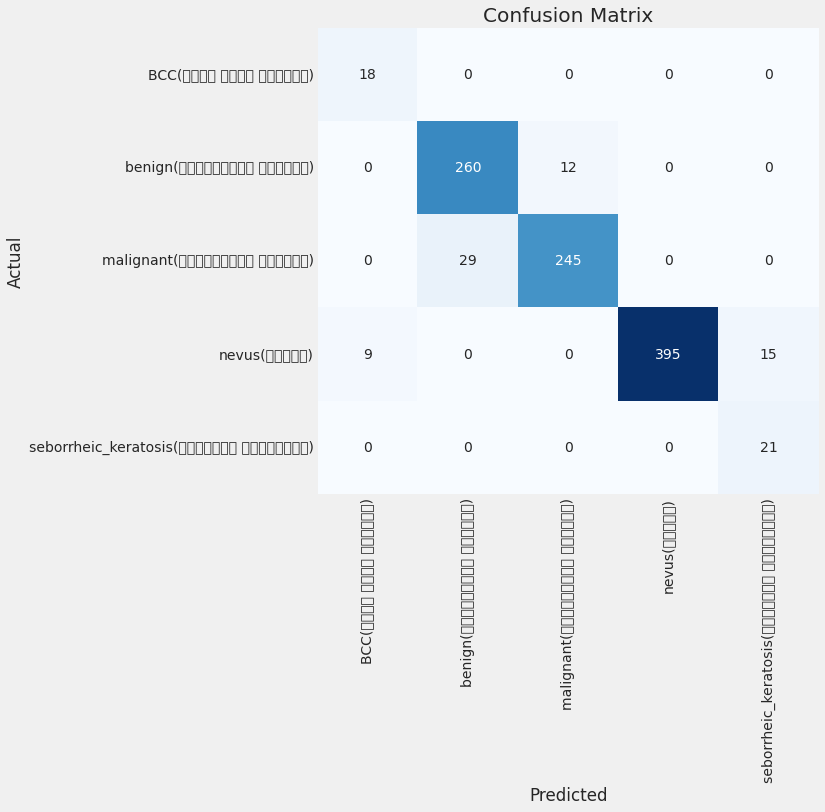

Classification Report:
----------------------
                                         precision    recall  f1-score   support

                 BCC(기저 세포 암종)       0.67      1.00      0.80        18
              benign(흑색종 양성)       0.90      0.96      0.93       272
           malignant(흑색종 악성)       0.95      0.89      0.92       274
                          nevus(모반)       1.00      0.94      0.97       419
seborrheic_keratosis(지루성 각화증)       0.58      1.00      0.74        21

                              accuracy                           0.94      1004
                             macro avg       0.82      0.96      0.87      1004
                          weighted avg       0.95      0.94      0.94      1004



In [66]:
# 테스트 셋에 대한 예측 & confusion matrix와 classification report 생성

print_code=0
preds=model.predict(test_gen) 
y_pred, y_true = print_info(test_gen, preds, print_code, save_dir, subject) 

In [67]:
pred_true = 0
pred_false = 0
index_false = []

for i in range(len(y_true)):
  if y_true[i] == y_pred[i]:
    pred_true = pred_true + 1
  else:
    pred_false = pred_false + 1
    index_false.append(i)

print('정확도 : {}%'.format(100 * round(pred_true / (pred_true + pred_false), 4)))
print('예측이 틀린 경우의 이미지 인덱스 리스트[test_df 기준] : \n{}'.format(index_false))

정확도 : 93.53%
예측이 틀린 경우의 이미지 인덱스 리스트[test_df 기준] : 
[2, 14, 33, 63, 87, 92, 98, 112, 126, 132, 136, 188, 197, 207, 212, 244, 259, 270, 290, 321, 331, 338, 350, 360, 370, 374, 381, 413, 420, 442, 451, 463, 464, 467, 539, 541, 552, 562, 567, 572, 596, 645, 669, 681, 694, 714, 721, 730, 753, 760, 763, 771, 811, 838, 861, 881, 889, 900, 916, 917, 954, 968, 970, 972, 989]


In [68]:
class_dict = test_gen.class_indices
class_dict_rev = {v:k for k, v in class_dict.items()}

In [72]:
def 피부암진단(i):
  image_path = test_df['file_pathes'].iloc[i]
  img=plt.imread(image_path)
  print('실제 검사자 상태 : {}\n학습모델이 예측한 상태 : {}'.format(class_dict_rev[y_true[i]], class_dict_rev[y_pred[i]]))
  print('사진출처 : {}'.format(test_df['file_pathes'].iloc[i]))
  imshow(img);

In [1]:
피부암진단(1003)

NameError: ignored

In [71]:
# Requirements.txt 제작

!pip freeze > requirements.txt

In [76]:
len(y_pred)

1004